
How to use TensorFlow to obtain derivatives of price option.
For this post I used tensorflow v2 which has a nicer API.

https://en.wikipedia.org/wiki/Greeks_(finance)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pprint import pprint

DTYPE = tf.float32
SEED = 3232

In [2]:
def initialize_variables(
    S0=100,
    strike=110,
    time_to_expiry=2,
    implied_vol=0.2,
    riskfree=0.03,
    to_tf=False
):
    """Initialize variables.

    Parameters
    ----------
    S0 : float
        Underlying spot price.
    strike : float
        Strike price.
    time_to_expiry : float
        Time to expiry.
    implied_vol : float
        Volatility.
    riskfree : float
        Risk free rate.
    to_tf : bool, optional
        Pass True to returns tensorflow variables.

    Returns
    -------
    out : dict
        A dictionary with the following keys:
        S0 : Spot price
        strike : Strike price
        time_to_expiry : Time of Maturity
        implied_vol : Volatility
        riskfree : Risk Free Rate
        to_tf : use tensorflow variables

    Examples
    --------
    >>> out = initialize_variables()
    >>> pprint(out)
    {'S0': 100,
     'implied_vol': 0.2,
     'riskfree': 0.03,
     'strike': 110,
     'time_to_expiry': 2}
    """
    if to_tf:
        S0 = tf.Variable(S0, dtype=DTYPE)
        strike = tf.Variable(strike, dtype=DTYPE)
        time_to_expiry = tf.Variable(time_to_expiry, dtype=DTYPE)
        implied_vol = tf.Variable(implied_vol, dtype=DTYPE)
        riskfree = tf.Variable(riskfree, dtype=DTYPE)

    out = dict(
            S0=S0,
            strike=strike,
            time_to_expiry=time_to_expiry,
            implied_vol=implied_vol,
            riskfree=riskfree,
        )

    return out

In [3]:
out = initialize_variables()
pprint(out)

{'S0': 100,
 'implied_vol': 0.2,
 'riskfree': 0.03,
 'strike': 110,
 'time_to_expiry': 2}


# Black-Scholes

In [4]:
@tf.function
def pricer_blackScholes(S0, strike, time_to_expiry, implied_vol, riskfree):
    """pricer_blackScholes.

    Parameters
    ----------
    S0 : tensorflow.Variable
        Underlying spot price.
    strike : tensorflow.Variable
        Strike price.
    time_to_expiry : tensorflow.Variable
        Time to expiry.
    implied_vol : tensorflow.Variable
        Volatility.
    riskfree : tensorflow.Variable
        Risk free rate.

    Returns
    -------
    npv : tensorflow.Tensor
        Net present value.

    Examples
    --------
    >>> kw = initialize_variables(to_tf=True)
    >>> pricer_blackScholes(**kw)
    <tf.Tensor: id=120, shape=(), dtype=float32, numpy=9.739834>

    Notes
    -----
    Formula: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model#Black%E2%80%93Scholes_formula
    """
    S       = S0
    K       = strike
    dt      = time_to_expiry
    dt_sqrt = tf.sqrt(dt)
    sigma   = implied_vol
    r       = riskfree
    Phi     = tf.compat.v1.distributions.Normal(0., 1.).cdf

    d1 = (tf.math.log(S / K) + (r + sigma ** 2 / 2) * dt) / (sigma * dt_sqrt)
    d2 = d1 - sigma * dt_sqrt

    npv =  S * Phi(d1) - K * tf.exp(-r * dt) * Phi(d2)
    return npv

In [5]:
out = initialize_variables()
pprint(out)

{'S0': 100,
 'implied_vol': 0.2,
 'riskfree': 0.03,
 'strike': 110,
 'time_to_expiry': 2}


In [6]:
def calculate_blackScholes():
    """calculate_blackScholes.

    Returns
    -------
    out : dict
        npv : net present value
        dv : First order derivates

    Examples
    --------
    >>> out = calculate_blackScholes()
    >>> pprint(out)
    {'dv': {'S0': 0.5066145,
            'implied_vol': 56.411205,
            'riskfree': 81.843216,
            'strike': -0.37201464,
            'time_to_expiry': 4.0482087},
     'npv': 9.739834}
    """
    variables = initialize_variables(to_tf=True)

    with tf.GradientTape() as g1:
        npv = pricer_blackScholes(**variables)
    dv = g1.gradient(npv, variables)

    dv = {k: v.numpy() for k,v in dv.items()}  # get the value
    return dict(npv=npv.numpy(), dv=dv)

In [7]:
out = calculate_blackScholes()
pprint(out)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
{'dv': {'S0': 0.5066145,
        'implied_vol': 56.411205,
        'riskfree': 81.843216,
        'strike': -0.37201464,
        'time_to_expiry': 4.0482087},
 'npv': 9.739834}


# Monte Carlo


In [12]:
@tf.function
def brownian(S0, dt, sigma, mu, dw):
    """Generates a brownian motion.

    Parameters
    ----------
    S0 : tensorflow.Variable
        Initial value of Spot.
    dt : tensorflow.Variable
        Time step.
    sigma : tensorflow.Variable
        Volatility.
    mu : tensorflow.Variable
        Mean, in black Scholes frame it's the risk free rate.
    dw : tensorflow.Variable
        Random variable.

    Returns
    -------
    out : numpy.array

    Examples
    --------
    >>> nsims = 10
    >>> nobs = 400
    >>> v = initialize_variables(to_tf=True)
    >>> S0 = v["S0"]
    >>> dw = tf.random.normal((nsims, nobs), seed=SEED)
    >>> dt = v["time_to_expiry"] / dw.shape[1]
    >>> sigma = v["implied_vol"]
    >>> r = v["riskfree"]
    >>> paths = np.transpose(brownian(S0, dt, sigma, r, dw))
    """
    dt_sqrt = tf.math.sqrt(dt)
    shock = sigma * dt_sqrt * dw
    drift = (mu - (sigma ** 2) / 2)
    bm = tf.math.exp(drift * dt + shock)
    out = S0 * tf.math.cumprod(bm, axis=1)
    return out

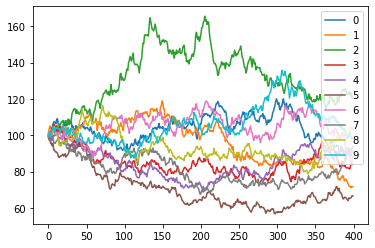

In [13]:
nsims = 10
nobs = 400
v = initialize_variables(to_tf=True)
S0 = v["S0"]
dw = tf.random.normal((nsims, nobs), seed=SEED)
dt = v["time_to_expiry"] / dw.shape[1]
sigma = v["implied_vol"]
r = v["riskfree"]
paths = np.transpose(brownian(S0, dt, sigma, r, dw))
pd.DataFrame(paths).plot()

In [14]:
@tf.function
def pricer_montecarlo(S0, strike, time_to_expiry, implied_vol, riskfree, dw):
    """Monte Carlo pricing method.

    Parameters
    ----------
    S0 : tensorflow.Variable
        Underlying spot price.
    strike : tensorflow.Variable
        Strike price.
    time_to_expiry : tensorflow.Variable
        Time to expiry.
    implied_vol : tensorflow.Variable
        Volatility.
    riskfree : tensorflow.Variable
        Risk free rate.
    dw : tensorflow.Variable
        Normal random variable.

    Returns
    -------
    npv : tensorflow.Variable
        Net present value.

    Examples
    --------
    >>> nsims = 10
    >>> nobs = 100
    >>> dw = tf.random.normal((nsims, nobs), seed=3232)
    >>> v = initialize_variables(to_tf=True)
    >>> npv = pricer_montecarlo(**v, dw=dw)
    >>> npv
    <tf.Tensor: id=646, shape=(), dtype=float32, numpy=28.780073>
    """
    sigma = implied_vol
    T = time_to_expiry
    r = riskfree
    K = strike
    dt = T / dw.shape[1]

    st = brownian(S0, dt, sigma, r, dw)
    payout = tf.math.maximum(st[:, -1] - K, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)

    return npv

In [15]:
nsims = 10
nobs = 100
dw = tf.random.normal((nsims, nobs), seed=3232)
v = initialize_variables(to_tf=True)
npv = pricer_montecarlo(**v, dw=dw)
npv

<tf.Tensor: id=770, shape=(), dtype=float32, numpy=7.9497027>

In [20]:
def calculate_montecarlo(greeks=True):
    """calculate_montecarlo.

    Returns
    -------
    out : dict
        npv : Net present value
        dv : First order derivatives
        d2v : Second order derivatives

    Examples
    --------
    >>> out = calculate_montecarlo()
    >>> pprint(out)
    {'d2v': {'S0': 0.59282005,
             'implied_vol': 13.493881,
             'riskfree': -124.43222,
             'strike': 0.75492465,
             'time_to_expiry': 51.805096},
     'dv': {'S0': 0.5065364,
            'implied_vol': 56.45906,
            'riskfree': 81.81441,
            'strike': -0.37188327,
            'time_to_expiry': 4.050169},
     'npv': 9.746445}
    """
    nsims = 10000000
    nobs = 2
    dw = tf.random.normal((nsims, nobs), seed=SEED)
    v = initialize_variables(to_tf=True)

    out = dict()

    if greeks:
        with tf.GradientTape() as g2:
            with tf.GradientTape() as g1:
                npv = pricer_montecarlo(**v, dw=dw)
            dv = g1.gradient(npv, v)
        d2v = g2.gradient(dv, v)

        out["dv"] = {k: v.numpy() for k, v in dv.items()}
        out["d2v"] = {k: v.numpy() for k, v in d2v.items()}
    else:
        npv = pricer_montecarlo(**v, dw=dw).numpy()

    out["npv"] = npv.numpy()
    return out

In [21]:
out = calculate_montecarlo()
pprint(out)

{'d2v': {'S0': 0.59196043,
         'implied_vol': 13.24057,
         'riskfree': -124.42546,
         'strike': 0.75488365,
         'time_to_expiry': 51.77191},
 'dv': {'S0': 0.50639206,
        'implied_vol': 56.37719,
        'riskfree': 81.80995,
        'strike': -0.37186304,
        'time_to_expiry': 4.0460086},
 'npv': 9.734236}


In [24]:
def test_brownian():
    nsims = 10000000
    nobs = 2
    dw = tf.random.normal((nsims, nobs), seed=SEED)
    v = initialize_variables()
    S0 = v["S0"]
    t = v["time_to_expiry"]
    dt = t / dw.shape[1]
    sigma = v["implied_vol"]
    r = v["riskfree"]
    paths = brownian(S0, dt, sigma, r, dw)

    obtained = np.mean(paths[:, -1])
    expected = np.exp(r * t) * S0

    tol = 0.01
    assert abs(obtained - expected) < tol, "%.3f , %.3f , %.3f" % (obtained, expected, abs(obtained-expected))

test_brownian()